In [ ]:
# Use the entire width of the screen if needed
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

---

Here is a good resource explaining the details of choosing t and C for the Hamiltonian Simulation and the controlled rotation respectively.

https://quantumcomputing.com/strangeworks/harrow-hassidim-lloyd-hhl-algorithm

---

In [1]:
# Reset the kernel if needed

%reset -f

In [2]:
# import the relevant libraries etc.
# set up the environment

from qiskit import *
import numpy as np


%matplotlib inline


In [3]:
# Define the problem (the tridiagonal matrix that we are interested in solving)

a = 1
b = 1/2

# Problem size
n_w = 5

In [4]:
# Define the eigenvalue register
n_l = 4

In [5]:
# Define the Trotterization
m = 1
# The order of the Trotter formula that we are using (shoot for the moon)

In [10]:
# Define the registers for the problem
work_register = QuantumRegister(n_w,name='work')
eigenvalue_register = QuantumRegister(n_l,name='eignvalue')
ancilla = AncillaRegister(1,name='controlled_rotation')


In [11]:
# Define the initial state of the system
# Implement this later after the unitary of the system is shown to be working fine



In [12]:
# Make a seperate circuit for the unitary, later turn this whole thing into a circuit and 
# apply controlled versions of this

unitary_circuit = QuantumCircuit(work_register,name='U')

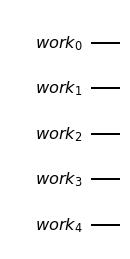

In [13]:
unitary_circuit.draw(output='mpl')

In [15]:
H1_circuit = QuantumCircuit(work_register,name='H1')

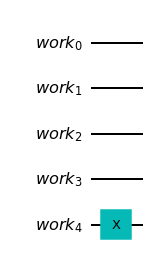

In [20]:
H1_circuit.draw(output='mpl')

In [19]:
H1_circuit.x(n_w-1)
H1_circuit.u1(n_w-1)
H1_circuit.x(n_w-1)
H1_circuit.u1(n_w-1)
